In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from toolz import compose
from aging.organization.dataframes import get_age
from aging.plotting import format_plots, PlotConfig, save_factory, figure

In [60]:
format_plots()
c = PlotConfig()
saver = save_factory(c.save_path / 'size-across-age', tight_layout=False)

In [2]:
df = pd.read_parquet("/n/groups/datta/win/longtogeny/data/ontogeny/version_08/ontogeny_males_syllable_df_v00.parquet")

In [3]:
age_map = {k: get_age(Path(k)) for k in df['file'].unique()}

In [4]:
df['age'] = df['file'].map(age_map)

In [25]:
np.sort(df['age'].unique())

array([  3,   5,   7,   9,  16,  20,  28,  32,  35,  36,  40,  44,  48,
        56,  60,  64,  68,  72,  80,  84,  90, 103])

In [26]:
df = df[~df['age'].isin([12, 24, 52, 78, 90])]

In [19]:
df = df[~df['session_name'].str.contains('CRL')]

In [27]:
areas = df.groupby(['uuid', 'age'])['area_px'].median()

In [28]:
mu = areas.groupby('age').mean()
sd = areas.groupby('age').std()

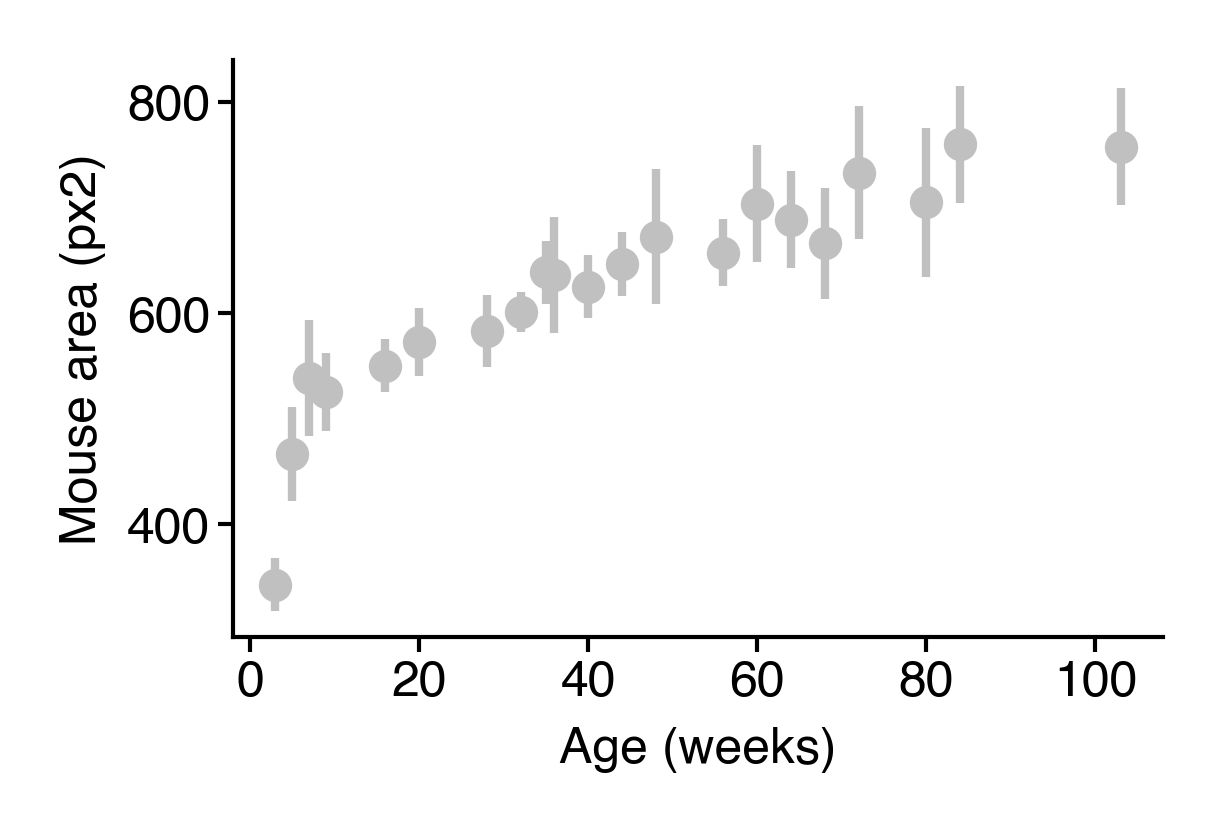

In [61]:
fig = figure(2, 1.25)
ax = fig.gca()
ax.errorbar(mu.index, y=mu, yerr=sd, fmt="o", markersize=3, color="silver")
ax.set(xlabel="Age (weeks)", ylabel="Mouse area (px2)")
sns.despine()
saver(fig, "mouse-area-errorbar");

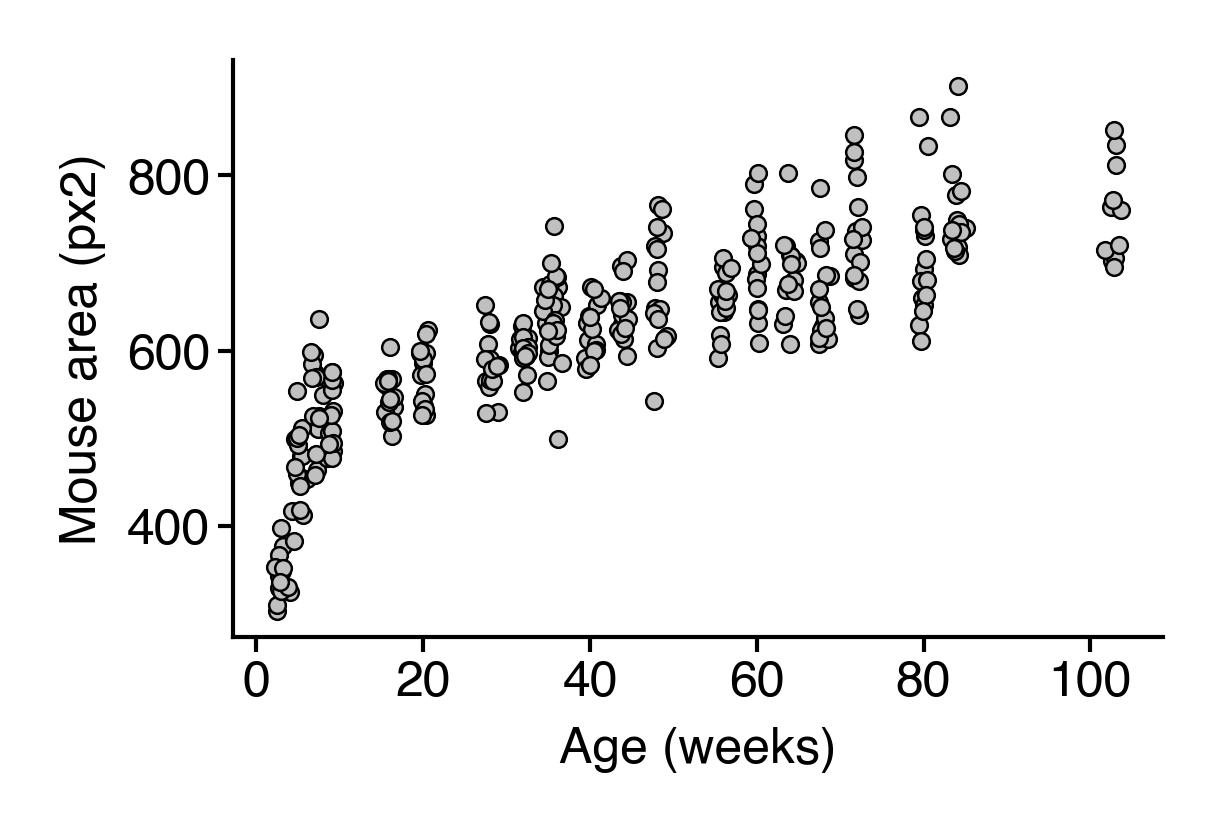

In [62]:
fig = figure(2, 1.25)
ax = fig.gca()
ax.scatter(areas.reset_index()['age'] + np.random.randn(len(areas)) * 0.4, areas, c='silver', s=4, lw=0.3, ec='k')
ax.set(xlabel="Age (weeks)", ylabel="Mouse area (px2)")
sns.despine()
saver(fig, "mouse-area-scatter");

## Use df to get frames from raw data and subtract affine transform

In [75]:
import cv2
import h5py
import joblib

In [71]:
def compute_frame_avg(frames, thresh=9):
    peaks = np.quantile(frames.reshape(len(frames), -1), 0.95, axis=1)
    peaks -= np.median(peaks)
    med_frame = np.median(frames[peaks < thresh], axis=0)
    return med_frame


def rescale(scale, img):
    '''scale input image'''
    warp_mat = cv2.getRotationMatrix2D((img.shape[0] // 2, img.shape[1] // 2), 0, scale)
    return cv2.warpAffine(img, warp_mat, img.shape, flags=cv2.INTER_LINEAR)


def rescale_data(frames):
    coef = joblib.load('/n/groups/datta/win/longtogeny/data/metadata/extraction_scaling.p')['coef']
    area = (compute_frame_avg(frames) > 10).sum()
    scale_factor = np.polyval(coef, area)
    frames = np.array([rescale(scale_factor, im) for im in frames])
    return frames

In [72]:
wk16_files = df.query('age == 16')['file'].unique()

In [112]:
n_frames = 10_000

In [ ]:
for f in wk16_files:
    with h5py.File(f, 'r') as h5f:
        frames = rescale_data(h5f['frames'][:n_frames])
        rec_frames = h5f['win_size_norm_frames_v6'][:n_frames]
    med_f = np.median(frames, axis=0)
    med_rec_f = np.median(rec_frames, axis=0)

In [127]:
wk103_files = df.query('age == 84')['file'].unique()

In [137]:
with h5py.File(wk103_files[1], 'r') as h5f:
    old_frames = rescale_data(h5f['frames'][:n_frames])
    old_rec_frames = h5f['win_size_norm_frames_v6'][:n_frames]

In [138]:
old_f = np.median(old_frames, axis=0)
old_rec_f = np.median(old_rec_frames, axis=0)

In [139]:
med_f[med_f < 4] = 0
old_f[old_f < 4] = 0
med_rec_f[med_rec_f < 4] = 0
old_rec_f[old_rec_f < 4] = 0

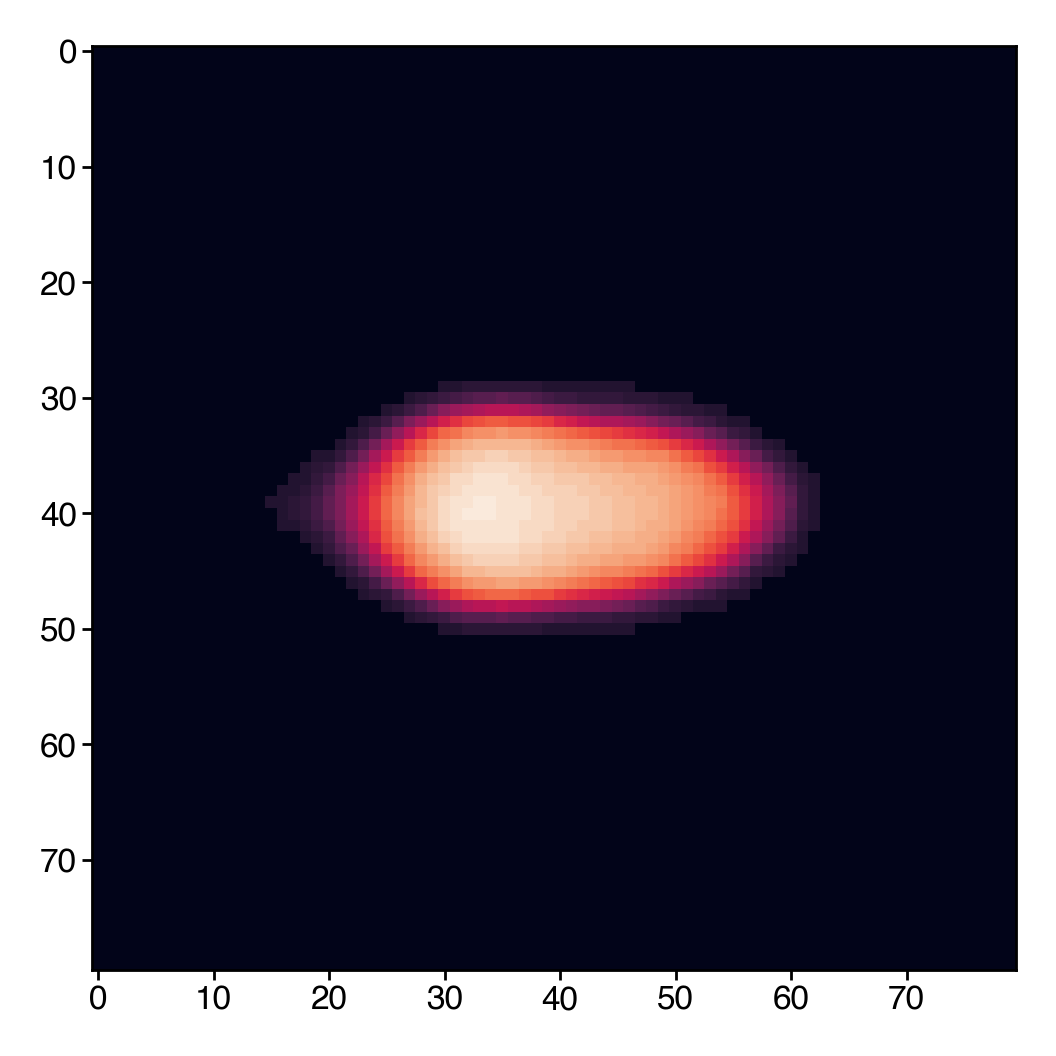

In [140]:
plt.imshow(med_f)

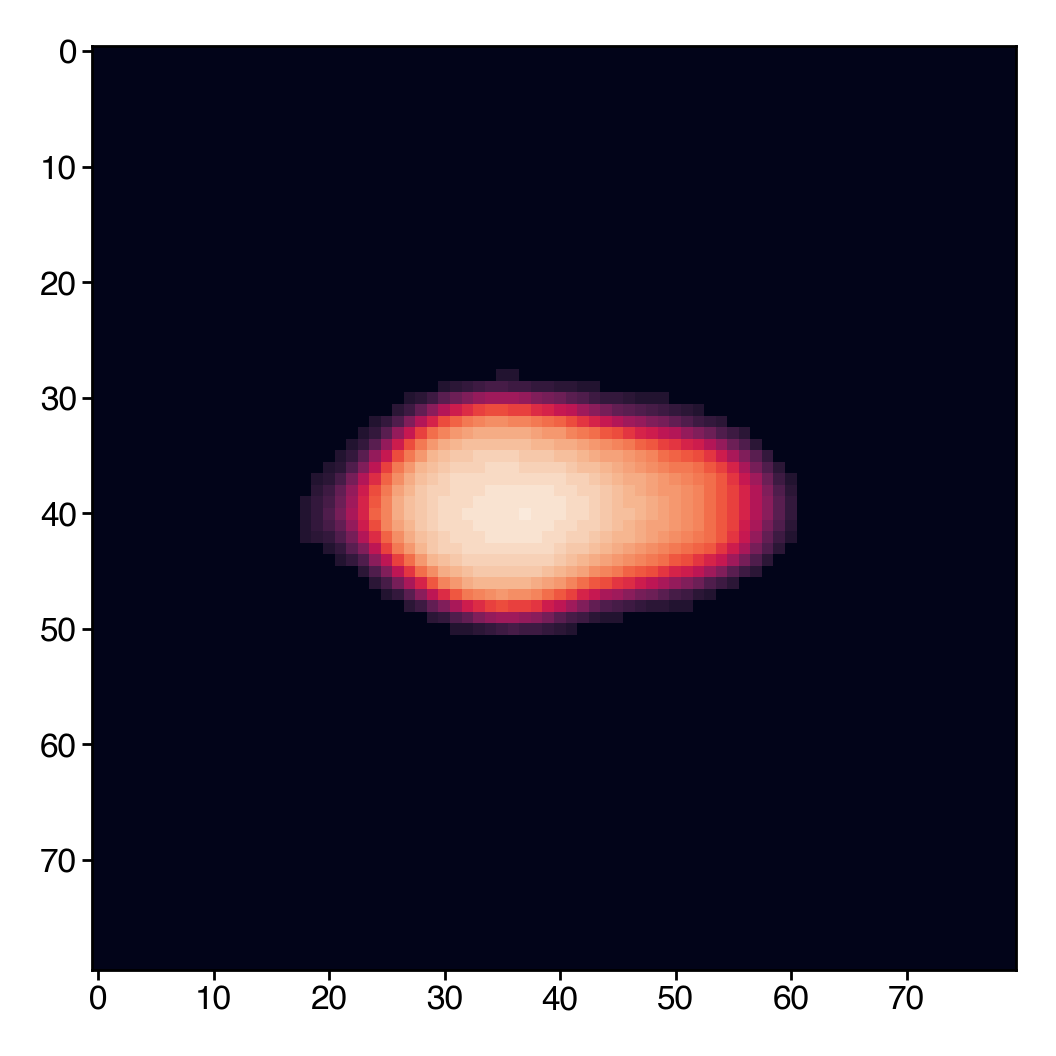

In [141]:
plt.imshow(old_f)

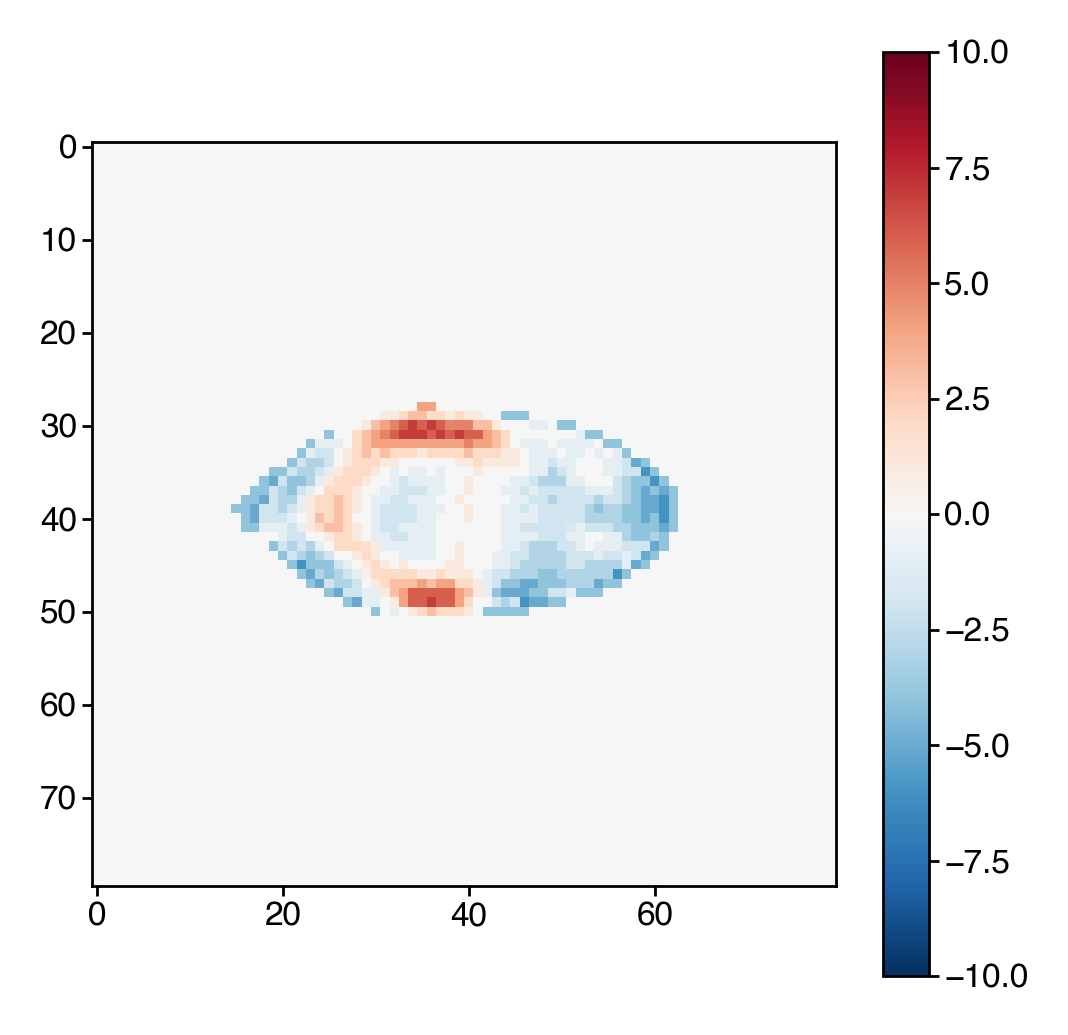

In [142]:
plt.imshow(old_f - med_f, cmap='RdBu_r', vmin=-10, vmax=10)
plt.colorbar()

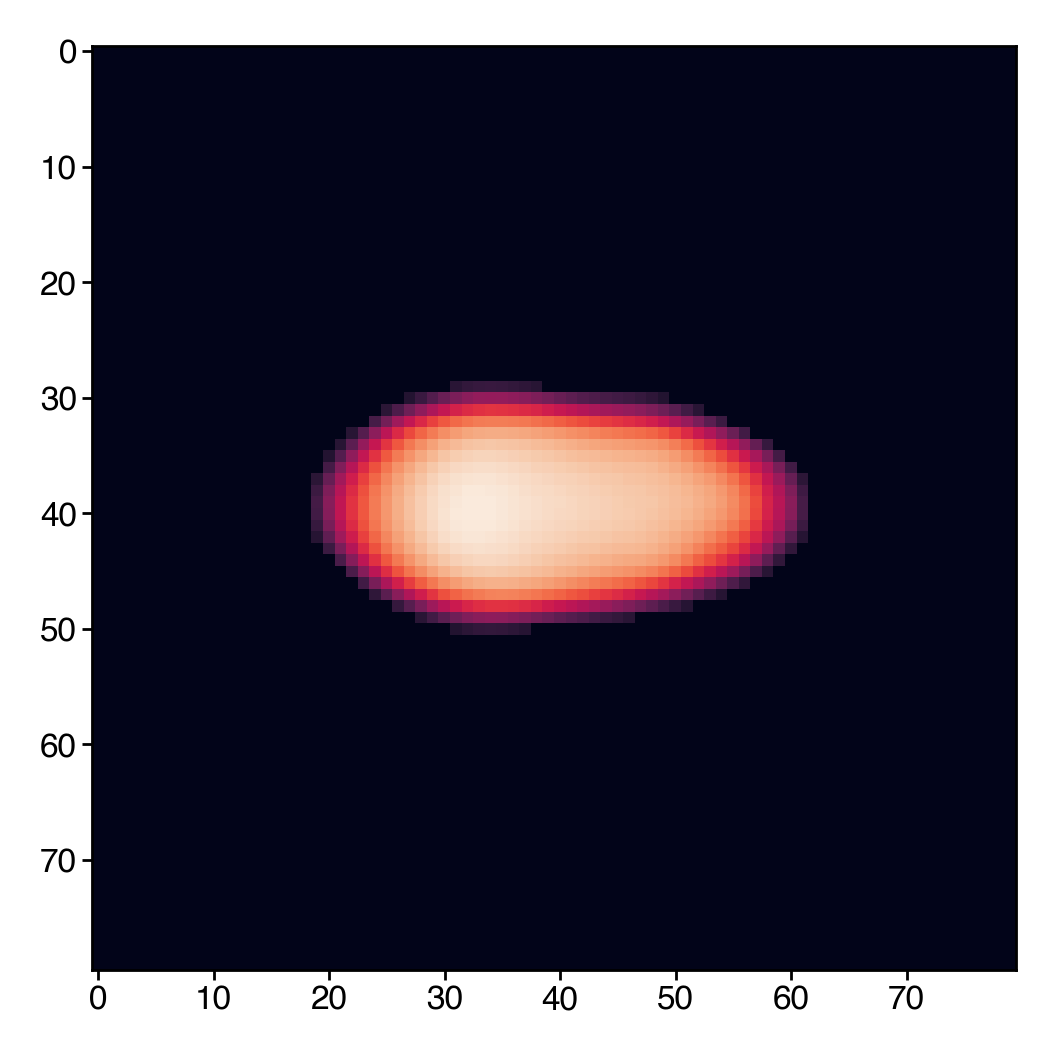

In [143]:
plt.imshow(med_rec_f)

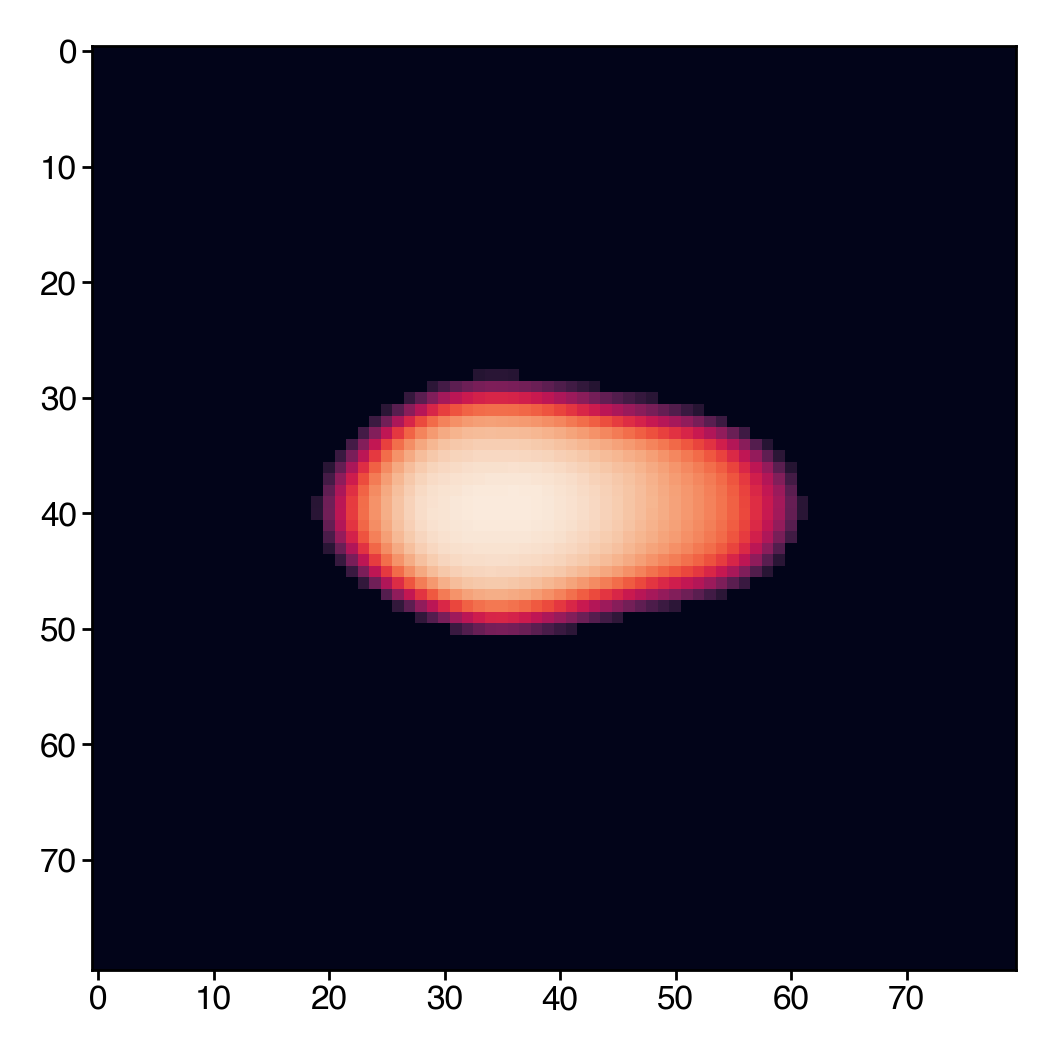

In [144]:
plt.imshow(old_rec_f)

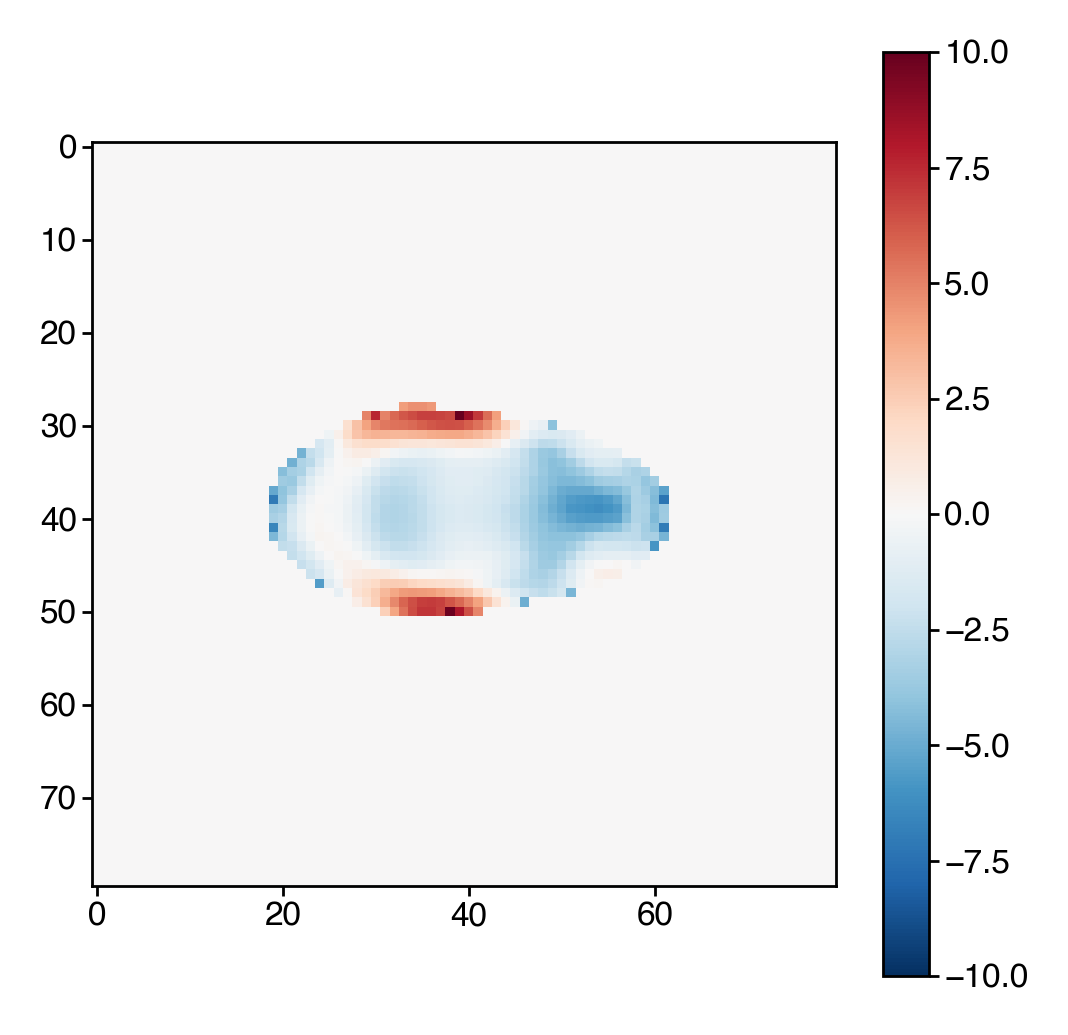

In [145]:
plt.imshow(old_rec_f - med_rec_f, cmap='RdBu_r', vmin=-10, vmax=10)
plt.colorbar()